In [1]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X).astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [9]:
X.shape

(1000, 2)

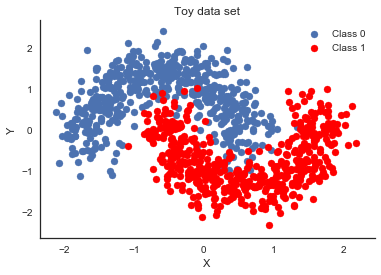

In [8]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy data set')

In [9]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    init_in_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_1_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_2_out = np.random.randn(n_hidden).astype(floatX)
    
    with pm.Model() as neural_network:
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), testval=init_in_1)
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                 shape=(n_hidden, n_hidden), testval=init_1_2)
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                 shape=(n_hidden,), testval=init_2_out)
        
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        
        out = pm.Bernoulli('out', act_out, observed=ann_output, 
                          total_size=Y_train.shape[0] #Important for mini-batches
                          )
    return neural_network

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [11]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

%time
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.15 µs


Average Loss = 193.07: 100%|██████████| 30000/30000 [00:07<00:00, 4048.41it/s]
Finished [100%]: Average Loss = 193


In [12]:
%time
with neural_network:
    advifit = pm.advi(n=30000)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs


Average ELBO = -197.67: 100%|██████████| 30000/30000 [00:06<00:00, 5120.82it/s]
Finished [100%]: Average ELBO = -196.12


In [13]:
trace = approx.sample(draws=5000)

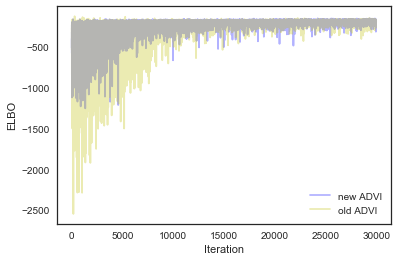

In [18]:
plt.plot(-inference.hist, label='new ADVI', color='b', alpha=0.3)
plt.plot(advifit.elbo_vals, label='old ADVI', color='y', alpha=0.3)
plt.ylabel('ELBO')
plt.xlabel('Iteration')
plt.legend()

In [19]:
neural_network.out.distribution.p

sigmoid.0

In [22]:
#Symbolic input
x = T.matrix('X')
n = T.iscalar('n')
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
# Do not forget test_values or set theano.config.compute_test_value = 'off'
_sample_proba = approx.sample_node(neural_network.out.distribution.p, 
                                  size=n,
                                  more_replacements={ann_input:x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

def production_step1():
    ann_input.set_value(X_test)
    ann_output.set_value(Y_test)
    with neural_network:
        ppc = pm.sample_ppc(trace, samples=500, progressbar=True)
        
        #prob > 0.5 to predict class 1
        pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(axis=0) > 0.5

In [23]:
%timeit production_step1()

100%|██████████| 500/500 [00:00<00:00, 3115.50it/s]

The slowest run took 16.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 168 ms per loop


In [24]:
%timeit production_step2()

10 loops, best of 3: 31.2 ms per loop


In [25]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

In [28]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predictions', xlabel='X', ylabel='Y')
print('Accuracy: {}'.format( (Y_test == pred).mean() * 100 ))

In [35]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)

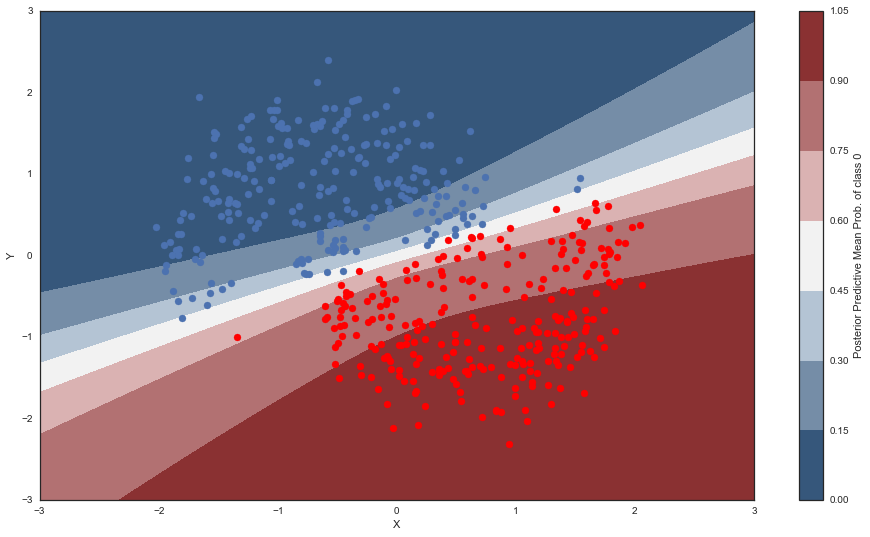

In [36]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Posterior Predictive Mean Prob. of class 0')

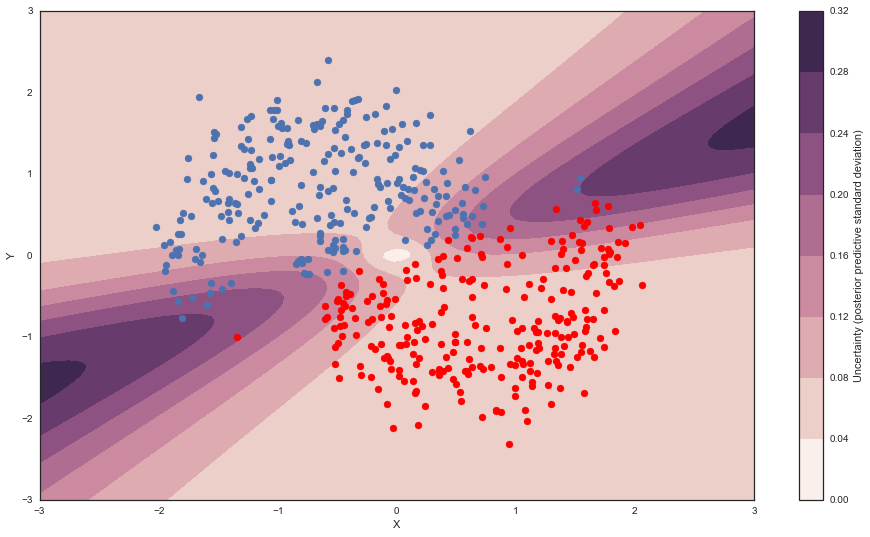

In [37]:
#Now the true power of Probabilistic Net
#Look at the standard deviations of the predictions
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y')
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')

In [38]:
#Use minibatch
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_net_minbatch = construct_nn(minibatch_x, minibatch_y)
with neural_net_minbatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 153.34: 100%|██████████| 40000/40000 [00:06<00:00, 6201.24it/s]
Finished [100%]: Average Loss = 153.28


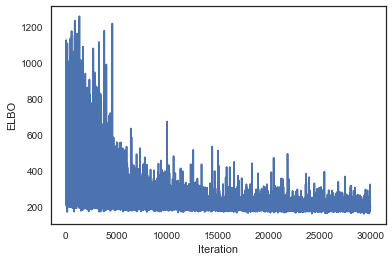

In [39]:
plt.plot(inference.hist)
plt.ylabel('ELBO'); plt.xlabel('Iteration')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122247210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119836850>]], dtype=object)

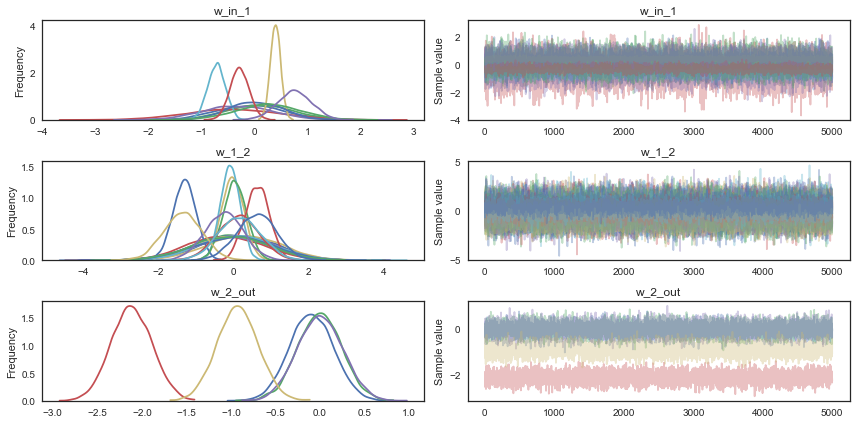

In [40]:
pm.traceplot(trace)

In [56]:
type (trace)

pymc3.backends.base.MultiTrace

In [ ]:
x